In [19]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "i386/"
files = os.listdir(path)
len(files)

5111

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [7]:
#path = "i386/"

def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [8]:
sample_code_dict = extract_code(path, sample_files)

In [9]:
len(sample_code_dict.keys())

100

In [10]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

eab9fa5bc86306b07cc928e35d1b3363	23266	[141, 76, 36, 4, 131, 228, 240, 255, 113, 252]
b0a42834c7e4a40b81c9539b55550b95	714690	[131, 236, 28, 139, 16, 3, 66, 244, 139, 80]
e7ea6c1fe51a1782224e4d3b49dd9fe3	161188	[85, 87, 137, 197, 86, 83, 232, 245, 67, 0]
be65736a4e6aad26fa528d403b47a345	54644	[141, 76, 36, 4, 131, 228, 240, 255, 113, 252]
7075cc409e67dc8c706fd3638841a174	76370	[131, 236, 16, 106, 1, 106, 0, 104, 64, 209]
796a441b1942b532e8bd66e74a464dca	224754	[131, 236, 28, 199, 4, 36, 173, 116, 9, 8]
58cdeaf2c9753708c67e214d5f3614e2	18784	[85, 137, 229, 131, 228, 240, 131, 236, 16, 139]
53bc4b1aa6e5ef85cb1e9fc9fcd3515b	11492	[85, 137, 229, 87, 86, 83, 131, 228, 240, 131]
a837dbbf44a45dd24309bfe69536e687	3086308	[83, 232, 90, 16, 1, 0, 129, 195, 242, 16]
2089b7d4cee721eb056868a7ff17fe1e	107426	[85, 137, 229, 131, 228, 240, 131, 236, 16, 139]
fc6bdc4ba12e3a9c6ea0772b97744238	69900	[85, 137, 229, 87, 86, 83, 131, 228, 240, 129]
117cf9905506450b53b42a05ab710012	10370	[141, 76, 36, 4, 131

In [11]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

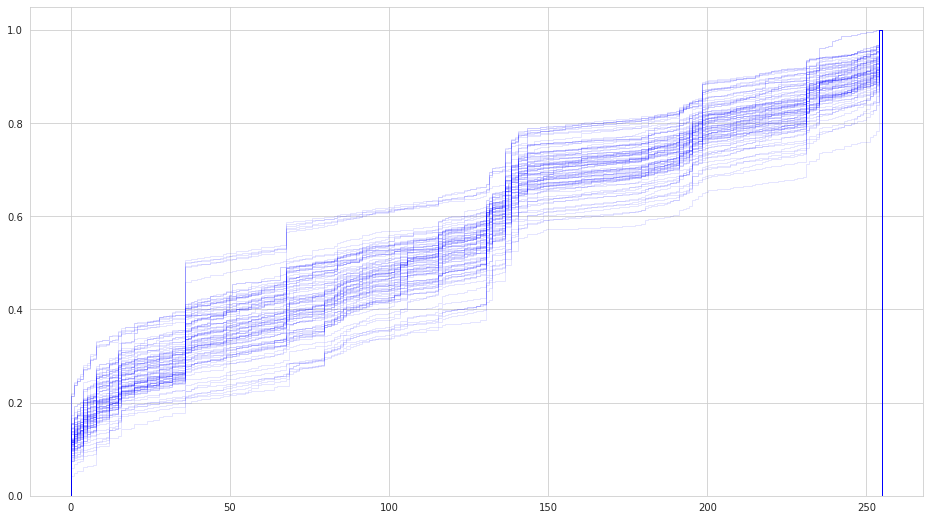

In [12]:
plot_dists(sample_code_dict)

In [13]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [14]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [17]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


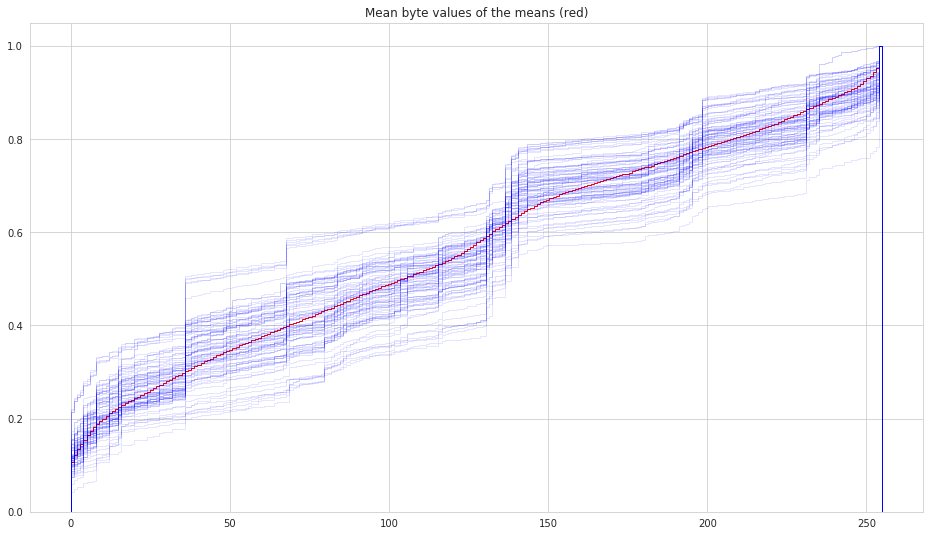

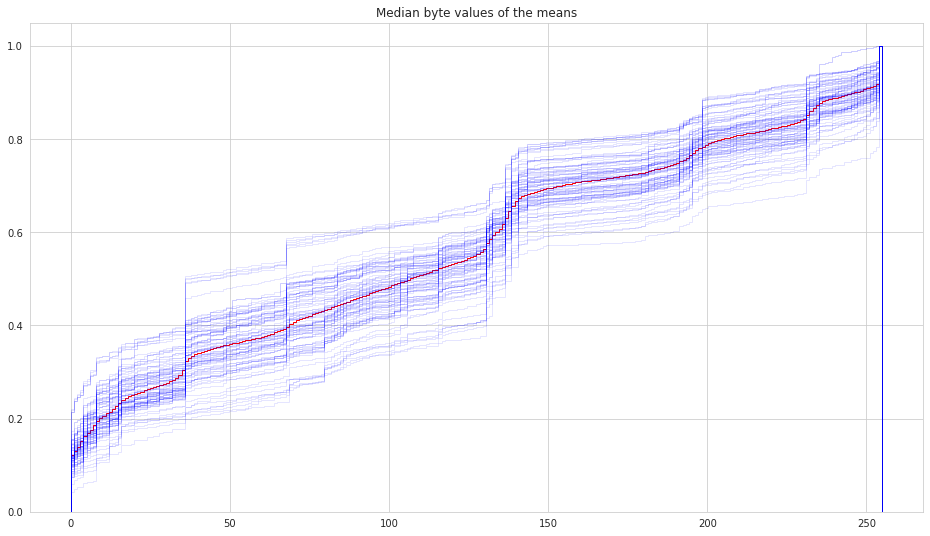

In [18]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

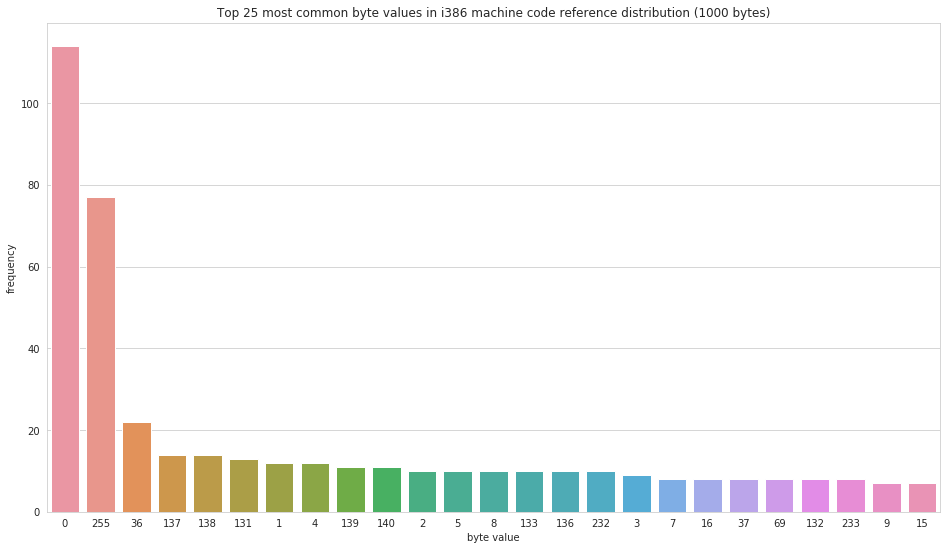

In [20]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in i386 machine code reference distribution (1000 bytes)")
plt.show()

In [21]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xff',
 '0x24',
 '0x89',
 '0x8a',
 '0x83',
 '0x1',
 '0x4',
 '0x8b',
 '0x8c',
 '0x2',
 '0x5',
 '0x8',
 '0x85',
 '0x88',
 '0xe8',
 '0x3',
 '0x7',
 '0x10',
 '0x25',
 '0x45',
 '0x84',
 '0xe9',
 '0x9',
 '0xf']

In [22]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [24]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [25]:
test_code_dict = extract_code(path, test_files, n_files=1000)

In [26]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

673752a2ea45e73daa2d234bc4b06bfd	35408	[85, 137, 229, 131, 228, 240, 131, 236, 16, 139]
f0e26a068d1b3d0571ed767715c42847	13106	[141, 76, 36, 4, 131, 228, 240, 255, 113, 252]
d476f45d5b8659821e7886678ea4a35f	20450	[83, 131, 236, 12, 139, 29, 232, 49, 5, 8]
670541bbe130059d0cac5ceae33b5566	17618	[131, 236, 28, 161, 96, 3, 5, 8, 199, 4]
17d648f1d97cea1ddb80ef7d2471c4ef	673940	[86, 83, 232, 153, 32, 0, 0, 129, 195, 109]
ddf45a0b86c0709493d3e706e32082d9	11628	[49, 237, 94, 137, 225, 131, 228, 240, 80, 84]
1f125fe2234f867f038a5a67d65e6dc8	32676	[141, 76, 36, 4, 131, 228, 240, 255, 113, 252]
739bbb7e27b697c50746c042cfd9a59f	74578	[131, 236, 28, 139, 16, 3, 66, 244, 139, 80]
563ed26e5a9e393d9f4740c9aedc2614	31312	[85, 137, 229, 131, 228, 240, 131, 236, 16, 139]
4dc91fff7b5d894c4d96a22740a6461d	45844	[87, 86, 83, 232, 184, 22, 0, 0, 129, 195]
8a929ae655285e9fe7e810ba4a74bcf4	10972	[141, 76, 36, 4, 131, 228, 240, 255, 113, 252]
19354d085948deebf0a0af93502322e4	11948	[141, 76, 36, 4, 131, 228, 24

In [27]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(1000, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
673752a2ea45e73daa2d234bc4b06bfd,35408,10.0474,0.964145,99.6657,87,83.8832
f0e26a068d1b3d0571ed767715c42847,13106,4.95471,0.495684,114.276,118,90.1356
d476f45d5b8659821e7886678ea4a35f,20450,2.9077,0.309732,111.973,108,90.2514
670541bbe130059d0cac5ceae33b5566,17618,12.7847,1.25983,96.8675,68,88.9862
17d648f1d97cea1ddb80ef7d2471c4ef,673940,26.1065,2.37306,135.758,137,89.6149
...,...,...,...,...,...,...
8c928e94e68c31efce7a727e8917bde6,36324,3.64362,0.377042,106.223,106,86.8446
82cac5a48a060ea232cb899379972ec2,62226,3.11637,0.385175,108.235,106,90.2055
3f778a2c10d61324713f225866f40add,162388,5.25191,0.560243,104.625,95,87.2775
cd193d6488c40d5291105f4f25318c11,38359,14.403,1.34816,124.05,128,91.064


In [28]:
test_results_df.mean()

size                    226627.968000
wasserstein distance        11.116541
energy distance              1.068371
mean                       111.760018
median                     108.181000
standard deviation          88.290224
dtype: float64

In [29]:
test_results_df.median()

size                    44251.000000
wasserstein distance        8.869856
energy distance             0.884566
mean                      111.196243
median                    116.000000
standard deviation         88.483432
dtype: float64

In [30]:
test_results_df["size"].sum()

226627968

In [31]:
test_results_df["size"].sum() / 1000000

226.627968

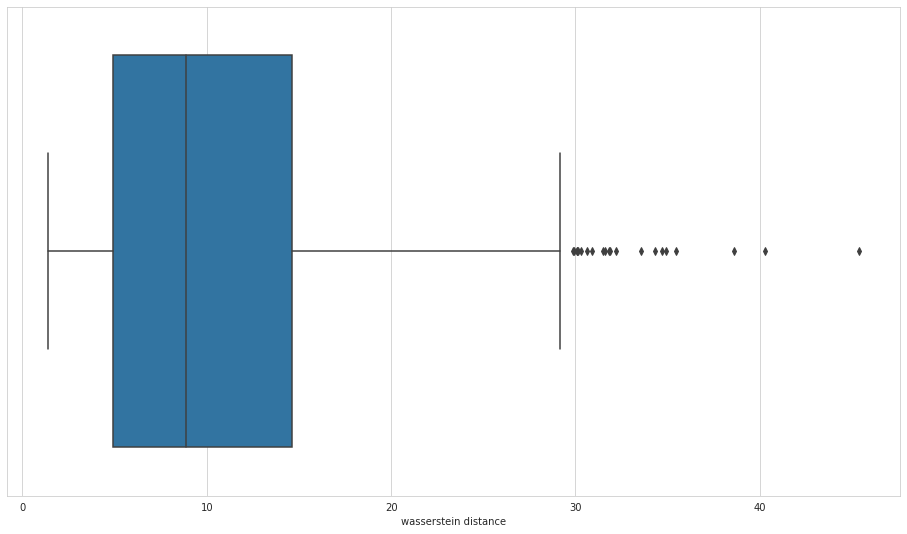

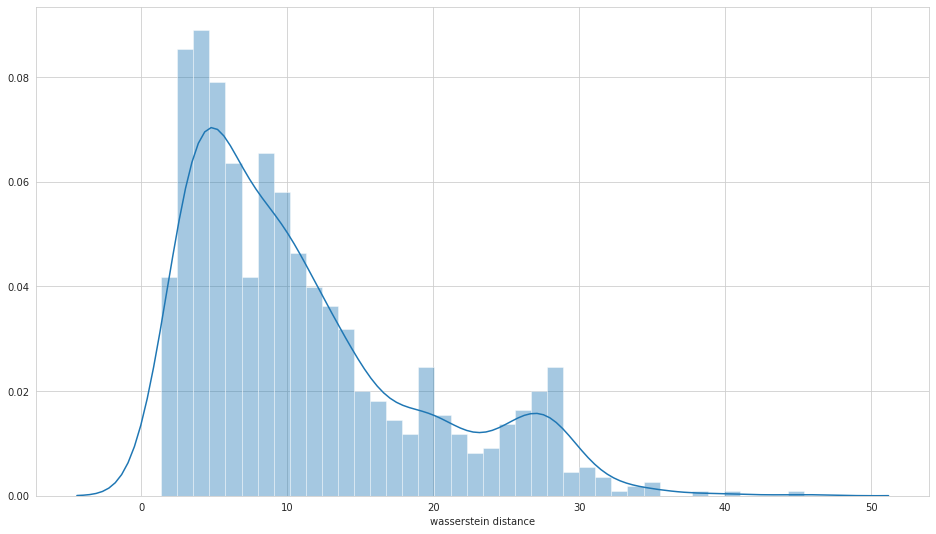

In [46]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

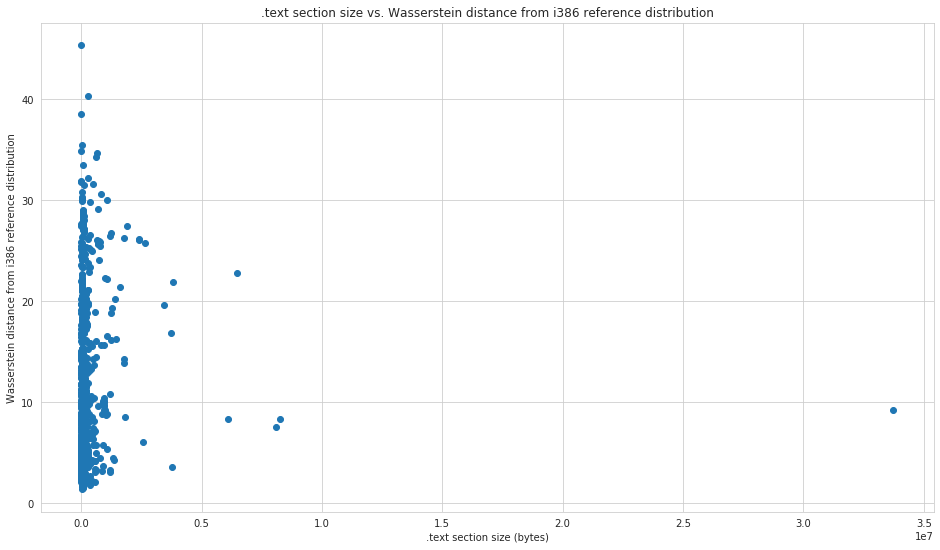

In [33]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from i386 reference distribution")
plt.title(".text section size vs. Wasserstein distance from i386 reference distribution")
plt.show()

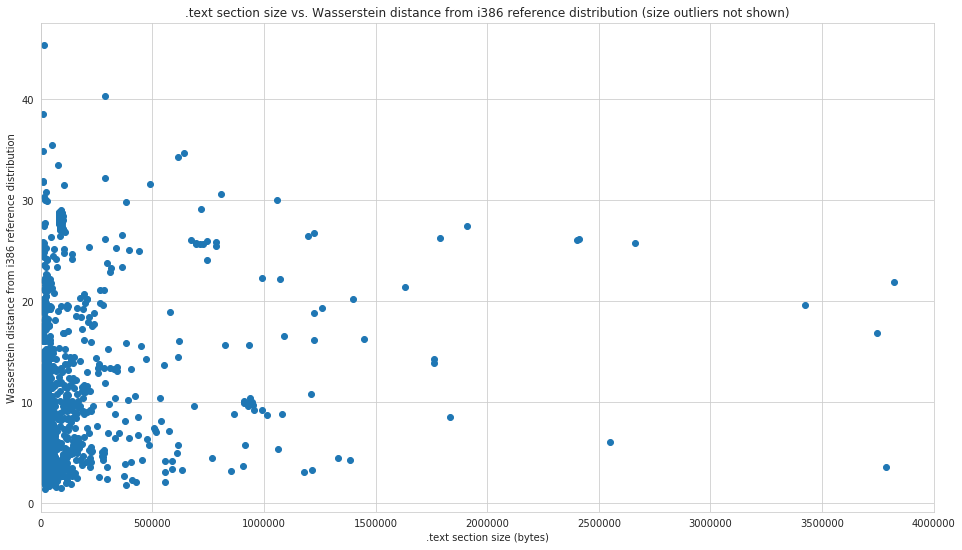

In [40]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from i386 reference distribution")
plt.title(".text section size vs. Wasserstein distance from i386 reference distribution (size outliers not shown)")
plt.xlim(0, 4000000)
plt.show()

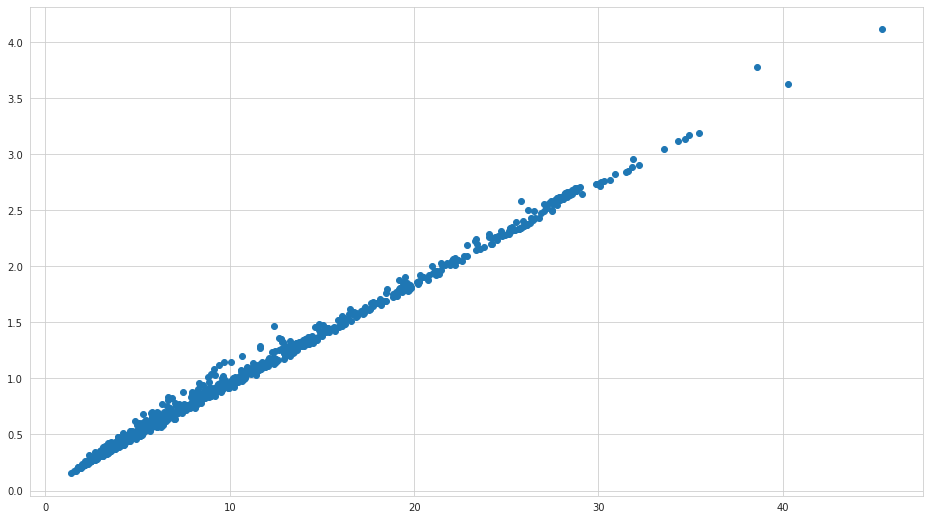

In [41]:
plt.scatter(test_results_df["wasserstein distance"], test_results_df["energy distance"])

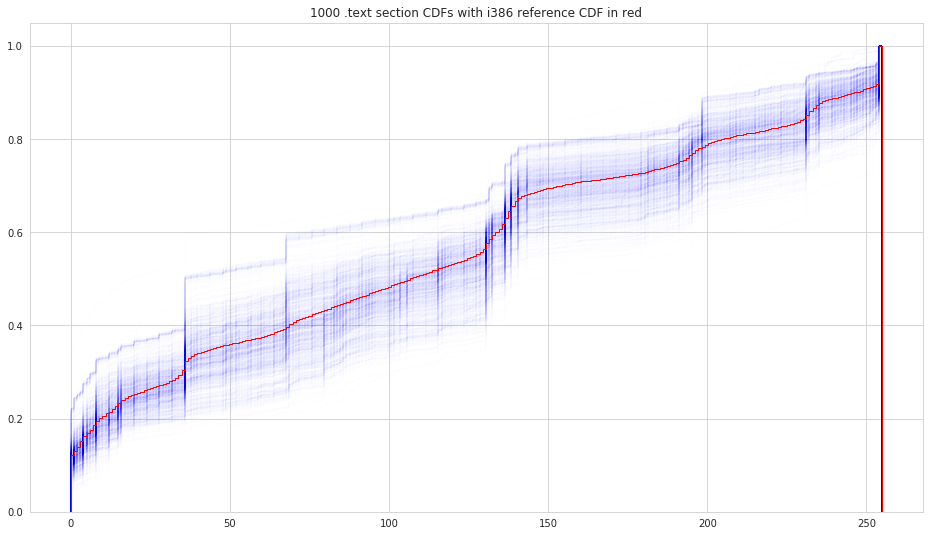

In [42]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with i386 reference CDF in red")
plt.show()

In [43]:
# export reference distribution
with open("i386_reference", "wb") as f:
    pickle.dump(median, f)